In [1]:
from src.optimize import RGD, RCG, OptimizationConfig
from src.tucker import Tucker
from src.matrix import TuckerMatrix

from src import backend as back
from src import set_backend

import numpy as np
import matplotlib.pyplot as plt
from time import time

Following examples illustrates calculation of minimal eigenvalue of the
symmetric positive defined matrix.

Let $R(x) = \frac{\langle x, Ax\rangle}{\|x\|^2}$ be Rayleigh quotient,
then $\min\limits_{x} R(x)$ is exactly minimal eigenvalue of self adjoint
linear operator $A$.

Let us represent $A$ as self adjoint linear operator on linear space
$\mathbb{R}^{n \times \ldots \times n}$. Then we might want to solve the
following problem

\begin{align*}
    \min\limits_{x \in \mathcal{M}_{\textbf{r}}} R(x).
\end{align*}

Where by $\mathcal{M}_{\textbf{r}}$ we denote Riemann submanifold of tensors
of fixed multilinear rank. So let us launch basic Riemann steepest descent to
find the solution:

In [2]:
"""
    A: operator on space R^{10 x 10}
    X: tensor from space R^{10 x 10}
"""

random_seed = 42
np.random.seed(random_seed)


def R(x: Tucker):
    return (x.flat_inner(A @ x)) / x.flat_inner(x)

n = 100
k = np.sqrt(n).astype(int)
A = back.tensor(np.random.randint(1, 11, n))
exact_solution = A.min()
A = back.diag(A)
Q = back.qr(back.randn((n, n), random_seed))[0]
A = Q @ A @ Q.T
A = TuckerMatrix.full2tuck(A.reshape([k] * 4),
                           [k] * 2, [k] * 2)

X = back.randn((n,))
X = Tucker.full2tuck(X.reshape([k] * 2))

config = OptimizationConfig(
    method_trace = True,
    tolerance = 1e-8)
start = time()
X, history = RGD(R, X, config)

print(f"Exact solution is \t{exact_solution}")
print("Found solution is \t%.6f" % R(X))
print("It took %.3f seconds and %d iterations to converge" % (time() - start, len(history["func"])))
print("||Ax - λx|| = %.6f" % (A @ X - R(X) * X).norm())

Exact solution is 	1
Found solution is 	1.000000
It took 6.435 seconds and 72 iterations to converge
||Ax - λx|| = 0.000001


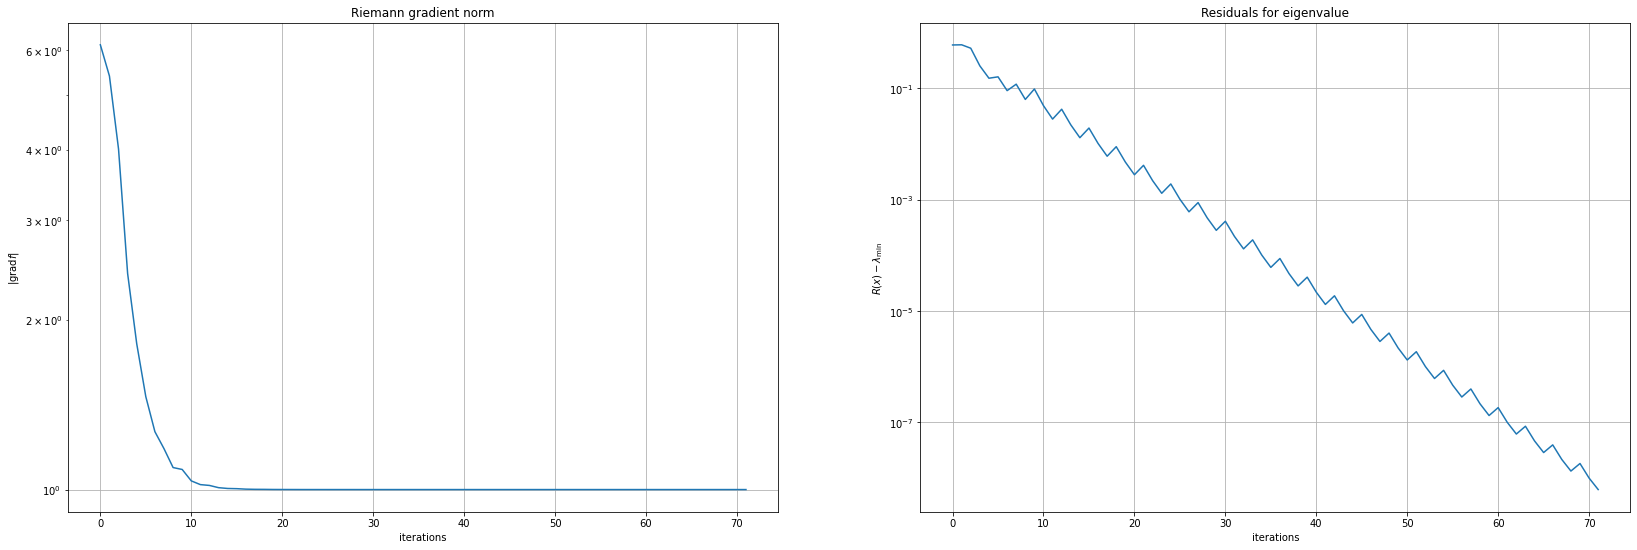

In [3]:
f, ax = plt.subplots(ncols=2, nrows=1, figsize=(28, 9))
ax[0].set(title="Riemann gradient norm", xlabel="iterations", ylabel=r"$\|\mathrm{grad} f\|$")
ax[1].set(title="Residuals for eigenvalue", xlabel="iterations", ylabel=r"$R(x) - \lambda_{\min}$")


ax[0].semilogy(np.arange(len(history["func"])), history["func"])
ax[1].semilogy(np.arange(len(history["grad_norm"])), history["grad_norm"])

ax[0].grid()
ax[1].grid()

plt.show()

Riemann steepest descent succsessfuly converges to minimal eigenvalue of our tensor operator. Howerever found tensor $X$ kinda far from corresponding eigenvector in terms of Frobenius norm.

Now let us launch more accurate optimization method: Rieman conjugate gradients:

In [4]:
X = back.randn((n,))
X = Tucker.full2tuck(X.reshape([k] * 2))

config = OptimizationConfig(
    method_trace = True,
    tolerance = 1e-8)
start = time()
X, history = RCG(R, X, config)

print(f"Exact solution is \t{exact_solution}")
print("Found solution is \t%.6f" % R(X))
print("It took %.3f seconds and %d iterations to converge" % (time() - start, len(history["func"])))
print("||Ax - λx|| = %.6f" % (A @ X - R(X) * X).norm())

Exact solution is 	1
Found solution is 	1.000000
It took 9.942 seconds and 101 iterations to converge
||Ax - λx|| = 0.000518


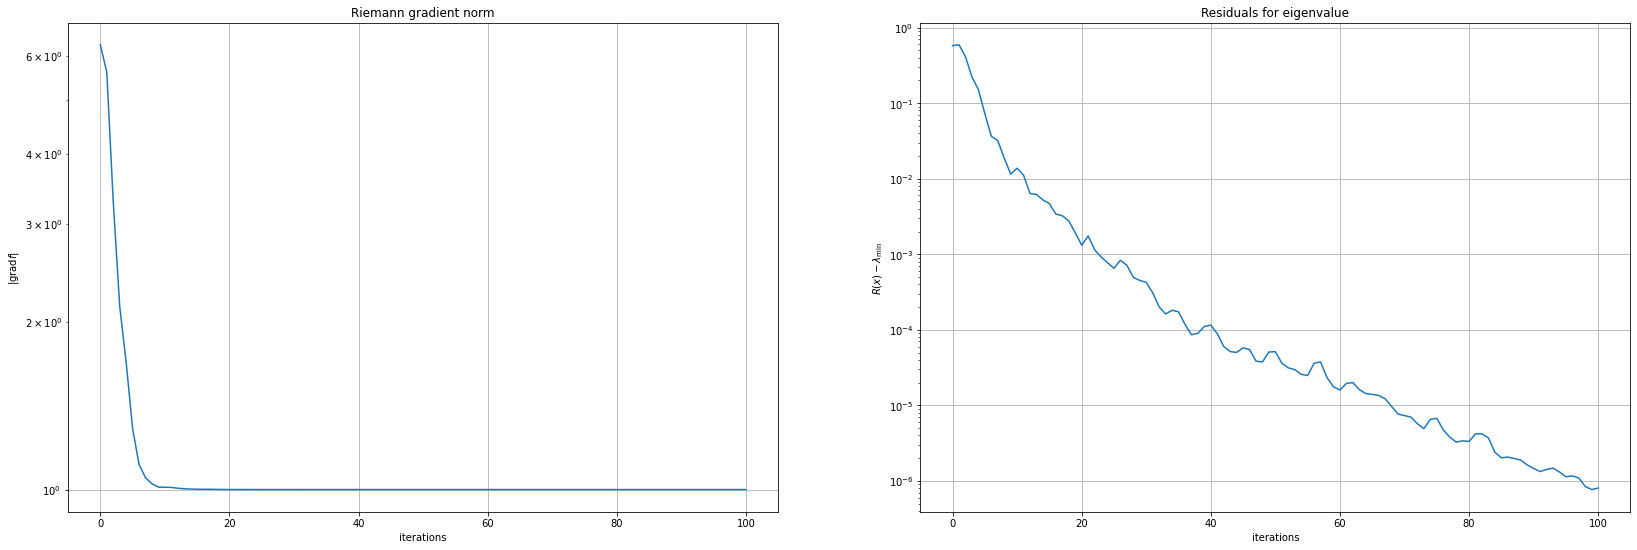

In [5]:
f, ax = plt.subplots(ncols=2, nrows=1, figsize=(28, 9))
ax[0].set(title="Riemann gradient norm", xlabel="iterations", ylabel=r"$\|\mathrm{grad} f\|$")
ax[1].set(title="Residuals for eigenvalue", xlabel="iterations", ylabel=r"$R(x) - \lambda_{\min}$")


ax[0].semilogy(np.arange(len(history["func"])), history["func"])
ax[1].semilogy(np.arange(len(history["grad_norm"])), history["grad_norm"])

ax[0].grid()
ax[1].grid()

plt.show()